In [64]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('figure.mplstyle')

In [2]:
# Plasmid used for Cas9 expression: pSQT817, 
data = pd.read_csv('guideseq_data.csv', header = 0)
filtered_data = data[data.iloc[:,10] < 5] # Only off-targets with 4 or less mismatches
# filtered_data[filtered_data['Targetsite'] == 'EMX1']
tsps = list(data['Targetsite'].unique())
print('site\ttarget_sequence')
for s in tsps:
    print(s + '\t' + data[data['Targetsite'] == s].iloc[0, 8])

site	target_sequence
VEGFA_site1	GGGTGGGGGGAGTTTGCTCCNGG
VEGFA_site2	GACCCCCTCCACCCCGCCTCNGG
VEGFA_site3	GGTGAGTGAGTGTGTGCGTGNGG
EMX1	GAGTCCGAGCAGAAGAAGAANGG
FANCF	GGAATCCCTTCTGCAGCACCNGG
RNF2	GTCATCTTAGTCATTACCTGNGG
HEK293_sgRNA1	GGGAAAGACCCAGCATCCGTNGG
HEK293_sgRNA2	GAACACAAAGCATAGACTGCNGG
HEK293_sgRNA3	GGCCCAGACTGAGCACGTGANGG
HEK293_sgRNA4	GGCACTGCGGCTGGAGGTGGNGG


Text(0, 0.5, 'Number of Mismatches')

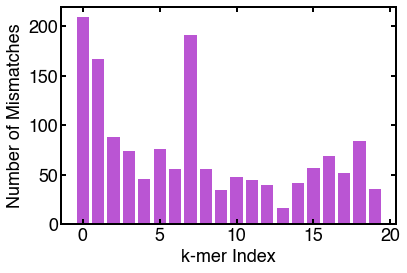

In [3]:
ts = data['Target_Sequence'].to_list() # On-target sequences
ots = data['Offtarget_Sequence'].to_list() # Off-target sequences
mismatch = [0] * 20
for m in range(len(ts)):
    for n in range(20):
        if ots[m][n] != ts[m][n]:
            mismatch[n] += 1
plt.bar([i for i in range(20)], mismatch, color = 'mediumorchid')
plt.xlabel('k-mer Index')
plt.ylabel('Number of Mismatches')

In [58]:
class Parse:
    def crisproff(filename):
        file = open('crisproff/' + filename + '.tsv')
        for i in range(9):
            file.readline()
        lines = file.readlines()
        for line in lines:
            line.split('\t')
            if len(line) > 1 and line[6] == 'CRITICAL':
                lines.append(line[3])
        
#         for i in range(10000):
#             line = file.readline().split('\t')
#             if line[6] == 'CRITICAL':
#                 lines.append(line[3])
        return ots

    def crispor(filename):
        ots = []
        file = open('crispor/' + filename + '.tsv')
        file.readline()
        lines = file.readlines()
        for line in lines:
            ots.append(line.split('\t')[2])
        return ots

    def cas_offinder(filename):
        ots = []
        file = open('cas_offinder/' + filename + '.txt')
        file.readline()
        lines = file.readlines()
        for line in lines:
            ots.append(line.split('\t')[2].upper())
        return ots
    
    def off_spotter(filename):
        ots = []
        file = open('off_spotter/' + filename + '.html')
        lines = file.readlines()
        for line in lines[:-1]:
            ots.append(line.split('\t')[5].replace('-', '').upper())
        return ots

In [60]:
sites = ['HEK293_sgRNA1', 'HEK293_sgRNA2', 'HEK293_sgRNA3', 'HEK293_sgRNA4', 'VEGFA_site1', 'VEGFA_site2', 'VEGFA_site3', 'EMX1', 'FANCF', 'RNF2']
def get_matches(sites, data, algorithm):
    donuts = {}
    for site in sites:
        donut = [0, 0, 0]
        ot_seqs = getattr(Parse, algorithm)(site)
        for ot in ot_seqs: # Off-target
            if ot in filtered_data[filtered_data['Targetsite'] == site].iloc[:,9].to_list():
                donut[0] += 1
            else:
                donut[2] += 1
        donut[1] = len(filtered_data[filtered_data['Targetsite'] == site].iloc[:, 1]) - donut[0]
        donuts[site] = donut
    return donuts
get_matches(sites, filtered_data, 'crisproff')
# Parse.crisproff('VEGFA_site1')

{'HEK293_sgRNA1': [9, 0, 404],
 'HEK293_sgRNA2': [3, 0, 410],
 'HEK293_sgRNA3': [6, 0, 407],
 'HEK293_sgRNA4': [121, 0, 292],
 'VEGFA_site1': [17, 0, 396],
 'VEGFA_site2': [81, 0, 332],
 'VEGFA_site3': [59, 0, 354],
 'EMX1': [16, 0, 397],
 'FANCF': [9, 0, 404],
 'RNF2': [1, 0, 412]}

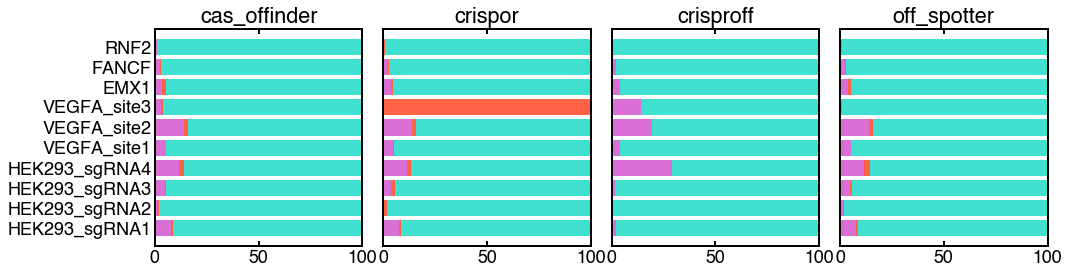

In [65]:
fig, axs = plt.subplots(1, 4, figsize = (16, 4), sharey = True, sharex = True, gridspec_kw = {'wspace': 0.1})
algos = ['cas_offinder', 'crispor', 'crisproff', 'off_spotter']
for i in range(4):
    matches = get_matches(sites, filtered_data, algos[i])
    mat = np.array(list(matches.values()))
    matched = mat[:, 0] * 100 / np.sum(mat, axis = 1)
    missed = mat[:, 1] * 100 / np.sum(mat, axis = 1)
    extras = mat[:, 2] * 100 / np.sum(mat, axis = 1)
    axs[i].barh(sites, matched, color = 'orchid')
    axs[i].barh(sites, missed, left = matched, color = 'tomato')
    axs[i].barh(sites, extras, left = missed + matched, color = 'turquoise')
    axs[i].set_title(algos[i])
